-----

# Import the modules that will do all the work


In [1]:
import pandas as pd # load and manipulate data and for One-Hot Encoding
import numpy as np # calculate the mean and standard deviation
import xgboost as xgb # XGBoost stuff
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer # for scoring during cross validation
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import ConfusionMatrixDisplay # creates and draws a confusion matrix

----

# Import the data
Now we load in a dataset from the **[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)**.
Specifically, we are going to use the **[Heart Disease Dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)**. This dataset will allow us to predict if someone has heart disease based on their sex, age, blood pressure and a variety of other metrics.

## Variable Description
| Variable Name | Role    | Type        | Demographic | Description                                                  | Units | Missing Values |
|---------------|---------|-------------|-------------|--------------------------------------------------------------|-------|----------------|
| age           | Feature | Integer     | Age         |                                                              | years | no             |
| sex           | Feature | Categorical | Sex         |                                                              |       | no             |
| cp            | Feature | Categorical |             |                                                              |       | no             |
| trestbps      | Feature | Integer     |             | resting blood pressure (on admission to the hospital)        | mm Hg | no             |
| chol          | Feature | Integer     |             | serum cholestoral                                            | mg/dl | no             |
| fbs           | Feature | Categorical |             | fasting blood sugar > 120 mg/dl                              |       | no             |
| restecg       | Feature | Categorical |             |                                                              |       | no             |
| thalach       | Feature | Integer     |             | maximum heart rate achieved                                  |       | no             |
| exang         | Feature | Categorical |             | exercise induced angina                                      |       | no             |
| oldpeak       | Feature | Integer     |             | ST depression induced by exercise relative to rest           |       | no             |

In [2]:
df = pd.read_csv('processed.cleveland.data', 
                 header=None)

Now that we have loaded the data into a **data frame** called **df**, let's look at the first five rows using the `head()` function:

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Add column names to the data
- **age**,
- **sex**,
- **cp**, chest pain
- **restbp**, resting blood pressure (in mm Hg)
- **chol**, serum cholesterol in mg/dl
- **fbs**, fasting blood sugar
- **restecg**, resting electrocardiographic results
- **thalach**,  maximum heart rate achieved
- **exang**, exercise induced angina
- **oldpeak**, ST depression induced by exercise relative to rest
- **slope**, the slope of the peak exercise ST segment.
- **ca**, number of major vessels (0-3) colored by fluoroscopy
- **thal**, this is short of thalium heart scan.
- **hd**, diagnosis of heart disease, the predicted attribute

In [4]:
df.columns = ['age', 
              'sex', 
              'cp', 
              'restbp', 
              'chol', 
              'fbs', 
              'restecg', 
              'thalach', 
              'exang', 
              'oldpeak', 
              'slope', 
              'ca', 
              'thal', 
              'hd']
df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0



----


#  Identifying Missing Data



In [5]:
df.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca             str
thal           str
hd           int64
dtype: object

We see that they are almost all `float64`, however, two columns, **ca** and **thal**, have the `object` type and one column, **hd** has `int64`.



In [6]:
df['ca'].unique()

<StringArray>
['0.0', '3.0', '2.0', '1.0', '?']
Length: 5, dtype: str

We see that **ca** contains numbers (0.0, 3.0, 2.0 and 1.0) and questions marks (?). The numbers represent the number of blood vessels that we lit up by fluoroscopy and the question marks represent missing data.

Now let's look at the unique values in **thal**.

In [7]:
df['thal'].unique()

<StringArray>
['6.0', '3.0', '7.0', '?']
Length: 4, dtype: str

Again, **thal** also contains a mixture of numbers, representing the different diagnoses from the thalium heart scan, and question marks, which represent missing values.

Now that we have identified some missing values, we need to deal with them.


----


# Dealing With Missing Data

One thing that is relatively unique about **XGBoost** is that it determines default behavior for missing data. So all we have to do is identify missing values and make sure they are set to `0`.


In [8]:
len(df.loc[(df['ca'] == '?') 
           | 
           (df['thal'] == '?')])

6

Since only 6 rows have missing values, let's look at them.

In [9]:
df.loc[(df['ca'] == '?') 
       | 
       (df['thal'] == '?')]

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


Now let's count the number of rows in the full dataset.

In [10]:
len(df)

303

So 6 of the **303** rows, or **2%**, contain missing values. So let's just set the missing values, `?`, to `0` and be done with this problem.

In [12]:
df.loc[(df['ca'] == '?'), 'ca'] = '0'
df.loc[(df['thal'] == '?'), 'thal'] = '0'

We can  make sure **ca** no longer contains question marks by printing its unique values:

In [13]:
df['ca'].unique()

<StringArray>
['0.0', '3.0', '2.0', '1.0', '0']
Length: 5, dtype: str

And we can also do the same thing for **thal**:

In [14]:
df['thal'].unique()

<StringArray>
['6.0', '3.0', '7.0', '0']
Length: 4, dtype: str

----

<a id="format-the-data"></a>
#  Split the Data into Dependent and Independent Variables


We will use the conventional notation of `X` (capital **X**) to represent the columns of data that we will use to make classifications and `y` (lower case **y**) to represent the thing we want to predict. In this case, we want to predict **hd** (heart disease).

In [15]:
X = df.drop('hd', axis=1).copy() # alternatively: X = df_no_missing.iloc[:,:-1]
X.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0


In [16]:
y = df['hd'].copy()
y.head()

0    0
1    2
2    1
3    0
4    0
Name: hd, dtype: int64

----


# Format the Data  One-Hot Encoding

Now that we have split the data frame into two pieces, `X`, which contains the data we will use to make, or predict, classifications, and `y`, which contains the known classifications in our training dataset, we need to take a closer look at the variables in `X`. The list below tells us what each variable represents and the type of data (**float** or **categorical**) it should contain:

- **age**, **Float**
- **sex** - **Category**
  - 0 = female
  - 1 = male
- **cp**, chest pain, **Category**
  - 1 = typical angina
  - 2 = atypical angina
  - 3 = non-anginal pain
  - 4 = asymptomatic
- **restbp**, resting blood pressure (in mm Hg), **Float**
- **chol**, serum cholesterol in mg/dl, **Float**
- **fbs**, fasting blood sugar, **Category**
  - 0 = >=120 mg/dl
  - 1 = <120 mg/dl
- **restecg**, resting electrocardiographic results, **Category**
  - 1 = normal
  - 2 = having ST-T wave abnormality
  - 3 = showing probable or definite left ventricular hypertrophy
- **thalach**,  maximum heart rate achieved, **Float**
- **exang**, exercise induced angina, **Category**
  - 0 = no
  - 1 = yes
- **oldpeak**, ST depression induced by exercise relative to rest. **Float**
- **slope**, the slope of the peak exercise ST segment, **Category**
  - 1 = upsloping
  - 2 = flat
  - 3 = downsloping
- **ca**, number of major vessels (0-3) colored by fluoroscopy, **Float**
- **thal**, thalium heart scan, **Category**
  - 3 = normal (no cold spots)
  - 6 = fixed defect (cold spots during rest and exercise)
  - 7 = reversible defect (when cold spots only appear during exercise)


In [17]:
X.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca             str
thal           str
dtype: object

In [18]:
X['cp'].unique()

array([1., 4., 3., 2.])

So, the good news is that **cp** only contains the values it is supposed to contain, so we will convert it, using **One-Hot Encoding**, into a series of columns that only contains **0s** and **1s**.

In [19]:
pd.get_dummies(X, columns=['cp']).head()

,age,sex,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,cp_1.0,cp_2.0,cp_3.0,cp_4.0
0,63.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,True,False,False,False
1,67.0,1.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,False,False,False,True
2,67.0,1.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,False,False,False,True
3,37.0,1.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,False,False,True,False
4,41.0,0.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,False,True,False,False


As we can see in the printout above, `get_dummies()` puts all of the columns it does not process in the front and it puts **cp** at the end. It also splits **cp** into **4** columns, just like we expected it. **cp_1.0** is `1` for any patient that scored a **1** for chest pain and `0` for all other patients. **cp_2.0** is `1` for any patient that scored **2** for chest pain and `0` for all other patients. **cp_3.0** is `1` for any patient that scored **3** for chest pain and **cp_4.0** is `1` for any patient that scored **4** for chest pain.

Now that we see how `get_dummies()` works, let's use it on the four categorical columns that have more than 2 categories and save the result.


In [20]:
X_encoded = pd.get_dummies(X, columns=['cp', 
                                       'restecg', 
                                       'slope', 
                                       'thal'])
X_encoded.head()

,age,sex,restbp,chol,fbs,thalach,exang,oldpeak,ca,cp_1.0,...,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0,thal_0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,True,...,False,False,True,False,False,True,False,False,True,False
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,False,...,False,False,True,False,True,False,False,True,False,False
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,False,...,False,False,True,False,True,False,False,False,False,True
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,False,...,True,False,False,False,False,True,False,True,False,False
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,False,...,False,False,True,True,False,False,False,True,False,False


Now, one last thing before we build an **XGBoost** model.  `y` doesn't just contain **0**s and **1**s. Instead, it has **5** different levels of heart disease. **0 =** no heart disease and **1-4** are various degrees of heart disease. We can see this with `unique()`:

In [21]:
y.unique()

array([0, 2, 1, 3, 4])

Since we're only making an **XGBoost** model that does simple classification and only care if someone has heart disease or not, we need to convert all numbers **> 0** to **1**.

In [22]:
y_not_zero_index = y > 0
y[y_not_zero_index] = 1
y.unique()

array([0, 1])

-----


# Convert all columns to Int, Float or Bool

**XGBoost** requires that all data be either `int`, `float` or `boolean` data types. We can use `dtypes` to see if there are any columns that need to be converted...

In [23]:
X_encoded.dtypes

age            float64
sex            float64
restbp         float64
chol           float64
fbs            float64
thalach        float64
exang          float64
oldpeak        float64
ca                 str
cp_1.0            bool
cp_2.0            bool
cp_3.0            bool
cp_4.0            bool
restecg_0.0       bool
restecg_1.0       bool
restecg_2.0       bool
slope_1.0         bool
slope_2.0         bool
slope_3.0         bool
thal_0            bool
thal_3.0          bool
thal_6.0          bool
thal_7.0          bool
dtype: object

...and we see we need to convert the column **ca** to a `float` or `integer`. We do this with the pandas function `to_numeric()`.

In [24]:
X_encoded['ca'] = pd.to_numeric(X_encoded['ca'])
X_encoded.dtypes

age            float64
sex            float64
restbp         float64
chol           float64
fbs            float64
thalach        float64
exang          float64
oldpeak        float64
ca             float64
cp_1.0            bool
cp_2.0            bool
cp_3.0            bool
cp_4.0            bool
restecg_0.0       bool
restecg_1.0       bool
restecg_2.0       bool
slope_1.0         bool
slope_2.0         bool
slope_3.0         bool
thal_0            bool
thal_3.0          bool
thal_6.0          bool
thal_7.0          bool
dtype: object

Now let's double check `y` and make sure it is either `float`, `int` or `boolean`.

In [25]:
y.dtypes

dtype('int64')


----


#  XGBoost Model


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)

clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                            seed=42)

clf_xgb.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

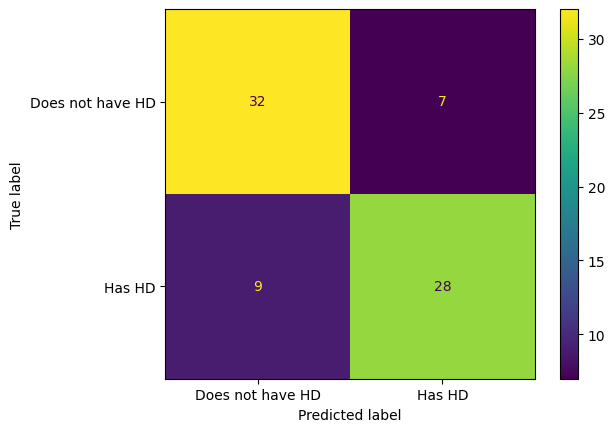

In [27]:
ConfusionMatrixDisplay.from_estimator(clf_xgb,
                                      X_test,
                                      y_test,
                                      display_labels=["Does not have HD", "Has HD"])

<!-- NOTE: because we included the missing data, we get different training/testing dataset from SVM and classification trees, so we get different results etc.
 -->
In the confusion matrix, we see that of the **31 + 8 = 39** people that did not have **Heart Disease**, **31 (79%)** were correctly classified. And of the **7 + 30 = 37** people that have **Heart Disease**, **30 (81%)** were correctly classified. Can we do better? One thing that might be holding this **XGBoost** back is that we have not tried to tune any of its many parameters. So let's optimize the parameters and see if we can improve classification.

----


# Optimize Parameters using Cross Validation and GridSearch()

**XGBoost** has a lot of *hyperparameters*, parameters that we have to manual configure and are not determined by XGBoost itself, including `n_estimators`, the number of **XGBoost Trees** to make, `max_depth`, the maximum tree depth, `learning_rate`, the learning rate, or "eta", `gamma`, the parameter that encourages pruning, and `reg_lambda`, the regularization parameter lambda. So let's try to find the optimal values for these hyperparameters in hopes that we can improve the accuracy with the **Testing Dataset**.


In [28]:
## NOTE: This code takes a few minutes to run, so I've commented it out.
## Since I set seed=42, we'll get the same results anyway, and those are
## coded into the next section...

param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'n_estimators': range(50, 250, 50),
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 0.5, 1.0],
    'reg_lambda': [0, 1.0, 10.0, 100.0]
}

optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=42),
    param_grid=param_grid,
#     scoring = 'roc_auc',## For more scoring metics see: 
        ## https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    verbose=0, # NOTE: If you want to see what Grid Search is doing, set verbose=2
    n_jobs = 10,
    cv = 5
)

optimal_params.fit(X_train, y_train)
print(optimal_params.best_params_)

{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'reg_lambda': 100.0}


So, after testing all possible combinations of the potential parameter values with **Cross Validation**, we see that we should set `gamma=1`, `learn_rate=0.1`, `max_depth=3`, `n_estimators=200` and `reg_lambda=100`.

----


#  Optimized XGBoost Model

Now that we have the ideal parameter values, we can build the final **XGBoost** model:

In [29]:
clf_xgb = xgb.XGBClassifier(seed=42,
                        objective='binary:logistic',
                        gamma=1,
                        learning_rate=0.1,
                        max_depth=3,
                        n_estimators=200,
                        reg_lambda=10)
clf_xgb.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

Now let's draw another confusion matrix to see if the optimized **XGBoost** model does better.

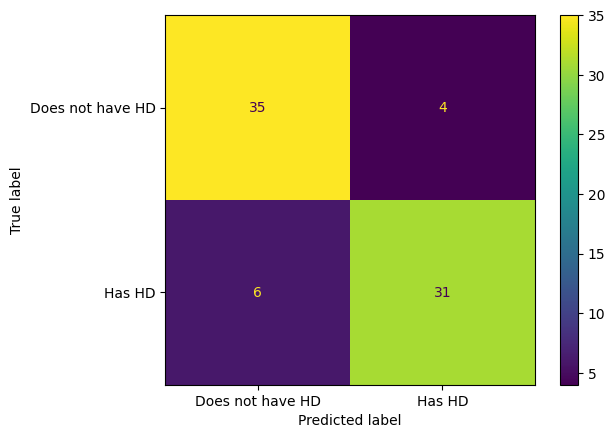

In [31]:
ConfusionMatrixDisplay.from_estimator(clf_xgb,
                                      X_test,
                                      y_test,
                                      display_labels=["Does not have HD", "Has HD"])

-----